In [ ]:
#Loading the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

np.random.seed(1000)

In [ ]:
#Attach the path to your dataset.
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv', encoding = "ISO-8859-1")

In [ ]:
#Checking for null values
print(df.info())
print("----Check if Data has any null values----")
print(df.isnull().sum())
if(df.isnull().values.any()==False):
    print("\nNo null Values in the dataset")
else:
    print("\ndataset has null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 666 entries, unnamed to data_659
dtypes: float64(660), int64(4), object(2)
memory usage: 22.0+ MB
None
----Check if Data has any null values----
unnamed     0
subject     0
session     0
ear         0
buffer      0
           ..
data_655    0
data_656    0
data_657    0
data_658    0
data_659    0
Length: 666, dtype: int64

No null Values in the dataset


In [ ]:
#Reading the csv file
df_again = pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df_again.head(3)

,unnamed,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21,data_22,data_23,data_24,data_25,data_26,data_27,data_28,data_29,data_30,data_31,data_32,data_33,...,data_620,data_621,data_622,data_623,data_624,data_625,data_626,data_627,data_628,data_629,data_630,data_631,data_632,data_633,data_634,data_635,data_636,data_637,data_638,data_639,data_640,data_641,data_642,data_643,data_644,data_645,data_646,data_647,data_648,data_649,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000064,0.000067,0.000069,0.000072,0.000074,0.000077,0.000078,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000081,0.000081,0.000081,0.000080,0.000080,0.000080,0.000081,0.000081,0.000082,0.000083,0.000084,0.000084,0.000085,...,-0.000063,-0.000063,-0.000064,-0.000063,-0.000063,-0.000062,-0.000061,-0.000061,-0.000060,-0.000059,-0.000057,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000050,-0.000049,-0.000047,-0.000046,-0.000044,-0.000043,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000043,-0.000044,-0.000045,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,0.000070,0.000072,0.000075,0.000077,0.000079,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000082,0.000081,0.000081,0.000081,0.000080,0.000079,0.000079,0.000080,0.000081,0.000081,0.000083,0.000083,0.000084,0.000084,...,-0.000055,-0.000055,-0.000055,-0.000055,-0.000054,-0.000053,-0.000052,-0.000052,-0.000052,-0.000050,-0.000049,-0.000048,-0.000047,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000036,-0.000035,-0.000034,-0.000034,-0.000034,-0.000034,-0.000035,-0.000036,-0.000036,-0.000037,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,0.000071,0.000074,0.000077,0.000079,0.000081,0.000082,0.000083,0.000085,0.000086,0.000087,0.000087,0.000087,0.000087,0.000086,0.000086,0.000084,0.000084,0.000083,0.000083,0.000082,0.000081,0.000081,0.000081,0.000082,0.000083,0.000083,0.000084,0.000085,0.000086,0.000086,...,-0.000059,-0.000059,-0.000059,-0.000058,-0.000057,-0.000057,-0.000056,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000051,-0.000049,-0.000047,-0.000046,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000037,-0.000037,-0.000038,-0.000039,-0.000039,-0.000040,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045


In [ ]:
#Dropping columns that are not used
df_again=df_again.drop(["unnamed", "session","ear","buffer","block"],axis=1)

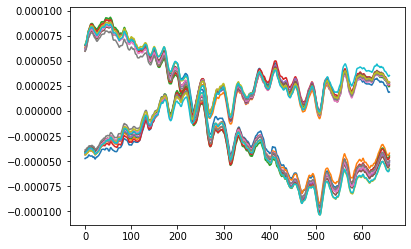

In [ ]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,1:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

Text(18, 97.9, '  98.05%')

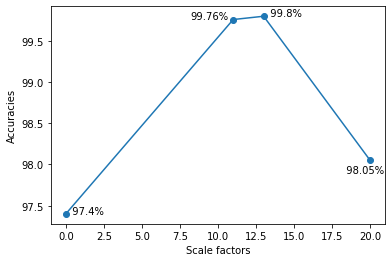

In [ ]:
#Scale factor testing
import matplotlib.pyplot as plt
import seaborn as sns

x_is = [0,11,13,20]
y_is = [97.4,99.76,99.8,98.05]

plt.xlabel("Scale factors")
plt.ylabel("Accuracies")

plt.scatter(x_is,y_is)
plt.plot(x_is,y_is)
plt.annotate("  97.4%", (0, 97.4))
plt.annotate("99.76%", (8.2, 99.76))
plt.annotate("  99.8%", (13, 99.8))
plt.annotate("  98.05%", (18, 97.9))

In [ ]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      unnamed  subject  session   ear  ...  data_656  data_657  data_658  data_659
2730    30662       34        0  left  ...  0.000009  0.000009  0.000009  0.000009
2731    30663       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2732    30664       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2733    30665       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2734    30666       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2735    30667       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2736    30668       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2737    30669       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2738    30670       34        0  left  ...  0.000009  0.000008  0.000008  0.000008
2739    30671       34        0  left  ...  0.000009  0.000008  0.000008  0.000008

[10 rows x 666 columns]


In [ ]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(54):
    #print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    #print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    #print(allInputTEOAEsignalsAllSubjects.shape)
    #print(allOutputLabelsAllSubjects.shape)


In [ ]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
xsave.to_pickle('dataX.pkl')
ysave.to_pickle('labelY.pkl')

In [ ]:
#Load from pkl files
X = pd.read_pickle('dataX.pkl')
y = pd.read_pickle('labelY.pkl')

In [ ]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(3456, 660)
(864, 660)
(3456, 1)
(864, 1)
(3456,)


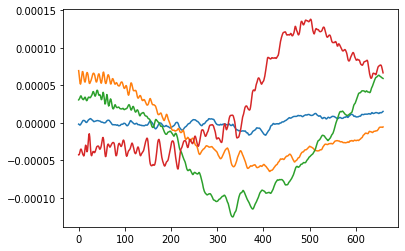

In [ ]:
# Check if continuous waves are similar to each other in X_train
for i in range(1,5):
    X_disp = X_train.iloc[i,:].values
    plt.plot(X_disp)
#Conclusion : NOPE!

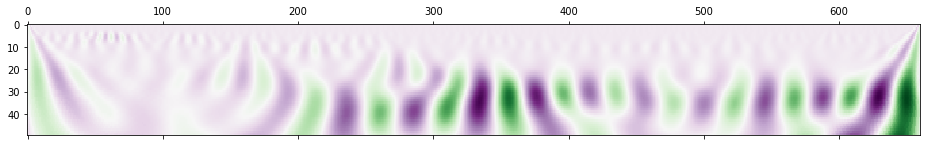

In [ ]:
#scales = range(1,661)
scales = range(1,51)
waveletname = 'morl'
train_size = 3456
test_size= 864

#################################################
### plotting CWT of a single TEOAE signal  ######
#################################################
coeff, freq = pywt.cwt(X_train.iloc[3,:], scales, waveletname, 1)
plt.matshow(coeff,  cmap='PRGn', aspect='auto')
plt.show()

In [ ]:
#CWT
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 660)) 

for ii in range(0,train_size):
    # if ii % 50 == 0: #len(X_train) == 0:
    #     print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 660))

for ii in range(0,test_size):
    # if ii % 50 == 0:
    #     print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

In [ ]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [ ]:
#Printing shapes
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(3456, 50, 660)
(864, 50, 660)
(3456,)
(864,)
3456
864


In [ ]:
# save numpy array
np.save('x_train_CNN', x_train)
np.save('x_test_CNN', x_test)
np.save('y_test_CNN', y_test_np)
np.save('y_train_CNN', y_train_np)

In [ ]:
#load data
x_train = np.load('x_train_CNN.npy')
x_test = np.load('x_test_CNN.npy')
y_train_np = np.load('y_train_CNN.npy')
y_test_np = np.load('y_test_CNN.npy')

In [ ]:
#ResNet50:
history = History()
 
img_x = x_train.shape[1] # = no.of samples of each TEOAE signal = 660
img_y = x_train.shape[2] 
img_z = 3

in_shape = (img_x, img_y, img_z)
print(in_shape)
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=in_shape,classes=54)

(50, 660, 3)
94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#ResNet50:
model= Sequential()
model.add(base_model)
model.add(Flatten())
#model.add(54,activation=('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 21, 2048)       23587712  
_________________________________________________________________
flatten (Flatten)            (None, 86016)             0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#ResNet50:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)
num_classes = 54




x_train_cnn = x_train.reshape(3456,50,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(864,50,660,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)
# y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
# y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

(3456, 50, 660)
(864, 50, 660)


In [ ]:
#Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
#obtain the flattened output for training
t0=time.clock()
features_xtrain=model.predict(rgb_train) #training
features_xtrain.shape
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


499.26976499999995


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [ ]:
#Flattened output for Testing
t0=time.clock()
features_xtest=model.predict(rgb_test) #testing
features_xtest.shape
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


125.331639


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [ ]:
# PCA on the flattened array

scaler = StandardScaler()
scaler.fit(features_xtrain)

features_xtrain = scaler.transform(features_xtrain)

pca = PCA(.95)  #using 95% of the variance in the model.
pca.fit(features_xtrain)
features_xtrain = pca.transform(features_xtrain)

t0=time.clock()

features_xtest = scaler.transform(features_xtest)

features_xtest = pca.transform(features_xtest)
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


1.3487970000001042


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Training Accuracy: 99.94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Testing accuracy: 100.0
1.0036790000001474


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


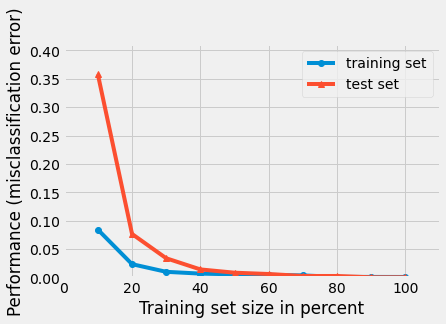

In [ ]:
#SVM classifier

svm=SVC()
svm.fit(features_xtrain,y_train_np)

#training accuracy
acc_svm_train=round(svm.score(features_xtrain,y_train_np)*100,2)
print("Training Accuracy:",acc_svm_train)
t0=time.clock()
#testing accuracy
acc_svm_test=round(svm.score(features_xtest,y_test_np)*100,2)
print("Testing accuracy:",acc_svm_test)
t1=time.clock()-t0
print(t1)

from mlxtend.plotting import plot_learning_curves

plot_learning_curves(features_xtrain, y_train_np, features_xtest, y_test_np, svm, scoring='misclassification error',print_model=False)
plt.show()

In [ ]:
# MLP classification

mlp_clf = MLPClassifier(hidden_layer_sizes=(100,150,100), max_iter=50, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=0,tol=0.000001)
mlp_clf.fit(features_xtrain, y_train_np)
t0=time.clock()
pred_test = mlp_clf.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100
t1=time.clock()-t0
print(t1)

Iteration 1, loss = 3.66499344
Iteration 2, loss = 2.09699228
Iteration 3, loss = 0.92651353
Iteration 4, loss = 0.32698529
Iteration 5, loss = 0.11351560
Iteration 6, loss = 0.04667287
Iteration 7, loss = 0.02443524
Iteration 8, loss = 0.01527089
Iteration 9, loss = 0.01140313
Iteration 10, loss = 0.00846483
Iteration 11, loss = 0.00679009
Iteration 12, loss = 0.00556955
Iteration 13, loss = 0.00470996
Iteration 14, loss = 0.00406389
Iteration 15, loss = 0.00352001
Iteration 16, loss = 0.00311716
Iteration 17, loss = 0.00277682
Iteration 18, loss = 0.00249496
Iteration 19, loss = 0.00227265
Iteration 20, loss = 0.00209417
Iteration 21, loss = 0.00191317
Iteration 22, loss = 0.00172765
Iteration 23, loss = 0.00159147
Iteration 24, loss = 0.00147801
Iteration 25, loss = 0.00137453
Iteration 26, loss = 0.00128458
Iteration 27, loss = 0.00120737
Iteration 28, loss = 0.00113642
Iteration 29, loss = 0.00106934
Iteration 30, loss = 0.00101301
Iteration 31, loss = 0.00096130
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Iteration 1, loss = 4.96546752
Iteration 2, loss = 4.13200768
Iteration 3, loss = 3.65141065
Iteration 4, loss = 3.29571089
Iteration 5, loss = 3.03290413
Iteration 6, loss = 2.79660128
Iteration 7, loss = 2.56561624
Iteration 8, loss = 2.33734949
Iteration 9, loss = 2.12123458
Iteration 10, loss = 1.90894143
Iteration 11, loss = 1.71318436
Iteration 12, loss = 1.52902117
Iteration 13, loss = 1.35947728
Iteration 14, loss = 1.20016760
Iteration 15, loss = 1.05571258
Iteration 16, loss = 0.92294333
Iteration 17, loss = 0.79720224
Iteration 18, loss = 0.68658439
Iteration 19, loss = 0.58546658
Iteration 20, loss = 0.49214357
Iteration 21, loss = 0.40791391
Iteration 22, loss = 0.33799900
Iteration 23, loss = 0.27552365
Iteration 24, loss = 0.22737999
Iteration 25, loss = 0.18689777
Iteration 26, loss = 0.15072635
Iteration 27, loss = 0.12291089
Iteration 28, loss = 0.09920510
Iteration 29, loss = 0.08037874
Iteration 30, loss = 0.06628555
Iteration 31, loss = 0.05527767
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 6, loss = 2.12967144
Iteration 7, loss = 1.79169501
Iteration 8, loss = 1.48218047
Iteration 9, loss = 1.20580834
Iteration 10, loss = 0.96162868
Iteration 11, loss = 0.75312210
Iteration 12, loss = 0.57879588
Iteration 13, loss = 0.43795167
Iteration 14, loss = 0.32634901
Iteration 15, loss = 0.24555739
Iteration 16, loss = 0.18238457
Iteration 17, loss = 0.13802148
Iteration 18, loss = 0.10430518
Iteration 19, loss = 0.08013110
Iteration 20, loss = 0.06163496
Iteration 21, loss = 0.04967368
Iteration 22, loss = 0.04038091
Iteration 23, loss = 0.03320928
Iteration 24, loss = 0.02756704
Iteration 25, loss = 0.02347395
Iteration 26, loss = 0.02031574
Iteration 27, loss = 0.01803962
Iteration 28, loss = 0.01618387
Iteration 29, loss = 0.01451559
Iteration 30, loss = 0.01318551
Iteration 31, loss = 0.01215570
Iteration 32, loss = 0.01121925
Iteration 33, loss = 0.01039741
Iteration 34, loss = 0.00973489
Iteration 35, loss = 0.00911479
Iteration 36, loss = 0.00857064
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 2.44093370
Iteration 5, loss = 1.96476428
Iteration 6, loss = 1.52485905
Iteration 7, loss = 1.14101283
Iteration 8, loss = 0.82299585
Iteration 9, loss = 0.57972708
Iteration 10, loss = 0.40093486
Iteration 11, loss = 0.28251559
Iteration 12, loss = 0.20304552
Iteration 13, loss = 0.14857838
Iteration 14, loss = 0.10784895
Iteration 15, loss = 0.08377024
Iteration 16, loss = 0.06240387
Iteration 17, loss = 0.04766982
Iteration 18, loss = 0.03738865
Iteration 19, loss = 0.03090424
Iteration 20, loss = 0.02531785
Iteration 21, loss = 0.02172000
Iteration 22, loss = 0.01917247
Iteration 23, loss = 0.01621172
Iteration 24, loss = 0.01455106
Iteration 25, loss = 0.01294699
Iteration 26, loss = 0.01159808
Iteration 27, loss = 0.01044543
Iteration 28, loss = 0.00953122
Iteration 29, loss = 0.00876080
Iteration 30, loss = 0.00812390
Iteration 31, loss = 0.00750602
Iteration 32, loss = 0.00701785
Iteration 33, loss = 0.00657356
Iteration 34, loss = 0.00617840
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 2.08274761
Iteration 5, loss = 1.53029614
Iteration 6, loss = 1.04830340
Iteration 7, loss = 0.67724034
Iteration 8, loss = 0.41724142
Iteration 9, loss = 0.25737876
Iteration 10, loss = 0.15769160
Iteration 11, loss = 0.09864613
Iteration 12, loss = 0.06485610
Iteration 13, loss = 0.04389954
Iteration 14, loss = 0.03264517
Iteration 15, loss = 0.02408803
Iteration 16, loss = 0.01989711
Iteration 17, loss = 0.01624303
Iteration 18, loss = 0.01353356
Iteration 19, loss = 0.01174709
Iteration 20, loss = 0.01037118
Iteration 21, loss = 0.00918276
Iteration 22, loss = 0.00827865
Iteration 23, loss = 0.00746292
Iteration 24, loss = 0.00682673
Iteration 25, loss = 0.00630390
Iteration 26, loss = 0.00579331
Iteration 27, loss = 0.00538273
Iteration 28, loss = 0.00500344
Iteration 29, loss = 0.00466830
Iteration 30, loss = 0.00438372
Iteration 31, loss = 0.00411360
Iteration 32, loss = 0.00387870
Iteration 33, loss = 0.00365343
Iteration 34, loss = 0.00345299
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 3.04620484
Iteration 3, loss = 2.29873968
Iteration 4, loss = 1.60179769
Iteration 5, loss = 0.98879679
Iteration 6, loss = 0.56293236
Iteration 7, loss = 0.30480308
Iteration 8, loss = 0.16624666
Iteration 9, loss = 0.09311325
Iteration 10, loss = 0.05648968
Iteration 11, loss = 0.03616488
Iteration 12, loss = 0.02585543
Iteration 13, loss = 0.01919426
Iteration 14, loss = 0.01528894
Iteration 15, loss = 0.01262954
Iteration 16, loss = 0.01054790
Iteration 17, loss = 0.00916989
Iteration 18, loss = 0.00803775
Iteration 19, loss = 0.00712648
Iteration 20, loss = 0.00639035
Iteration 21, loss = 0.00574647
Iteration 22, loss = 0.00524878
Iteration 23, loss = 0.00478283
Iteration 24, loss = 0.00439793
Iteration 25, loss = 0.00406550
Iteration 26, loss = 0.00377991
Iteration 27, loss = 0.00351300
Iteration 28, loss = 0.00327203
Iteration 29, loss = 0.00307448
Iteration 30, loss = 0.00289070
Iteration 31, loss = 0.00271979
Iteration 32, loss = 0.00256937
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 2.88027998
Iteration 3, loss = 1.99557402
Iteration 4, loss = 1.20185208
Iteration 5, loss = 0.63752880
Iteration 6, loss = 0.31993211
Iteration 7, loss = 0.15962468
Iteration 8, loss = 0.08262520
Iteration 9, loss = 0.04757252
Iteration 10, loss = 0.03013068
Iteration 11, loss = 0.02122049
Iteration 12, loss = 0.01618658
Iteration 13, loss = 0.01288134
Iteration 14, loss = 0.01059296
Iteration 15, loss = 0.00897436
Iteration 16, loss = 0.00774249
Iteration 17, loss = 0.00677085
Iteration 18, loss = 0.00599750
Iteration 19, loss = 0.00537329
Iteration 20, loss = 0.00486461
Iteration 21, loss = 0.00439401
Iteration 22, loss = 0.00401842
Iteration 23, loss = 0.00369988
Iteration 24, loss = 0.00338933
Iteration 25, loss = 0.00313699
Iteration 26, loss = 0.00290857
Iteration 27, loss = 0.00271479
Iteration 28, loss = 0.00253932
Iteration 29, loss = 0.00237995
Iteration 30, loss = 0.00224055
Iteration 31, loss = 0.00211167
Iteration 32, loss = 0.00199656
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 3, loss = 1.74491535
Iteration 4, loss = 0.95738942
Iteration 5, loss = 0.46322568
Iteration 6, loss = 0.22439908
Iteration 7, loss = 0.11285560
Iteration 8, loss = 0.06114167
Iteration 9, loss = 0.03659455
Iteration 10, loss = 0.02543208
Iteration 11, loss = 0.01884876
Iteration 12, loss = 0.01466662
Iteration 13, loss = 0.01188808
Iteration 14, loss = 0.00967791
Iteration 15, loss = 0.00817720
Iteration 16, loss = 0.00704550
Iteration 17, loss = 0.00613693
Iteration 18, loss = 0.00544945
Iteration 19, loss = 0.00489399
Iteration 20, loss = 0.00444717
Iteration 21, loss = 0.00401389
Iteration 22, loss = 0.00365378
Iteration 23, loss = 0.00335858
Iteration 24, loss = 0.00310955
Iteration 25, loss = 0.00286297
Iteration 26, loss = 0.00267492
Iteration 27, loss = 0.00249415
Iteration 28, loss = 0.00233470
Iteration 29, loss = 0.00218975
Iteration 30, loss = 0.00205933
Iteration 31, loss = 0.00194599
Iteration 32, loss = 0.00182929
Iteration 33, loss = 0.00173143
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 2.53367329
Iteration 3, loss = 1.47564095
Iteration 4, loss = 0.68768180
Iteration 5, loss = 0.28591717
Iteration 6, loss = 0.12055919
Iteration 7, loss = 0.05841862
Iteration 8, loss = 0.03107067
Iteration 9, loss = 0.01959937
Iteration 10, loss = 0.01410794
Iteration 11, loss = 0.01098176
Iteration 12, loss = 0.00886255
Iteration 13, loss = 0.00737274
Iteration 14, loss = 0.00640666
Iteration 15, loss = 0.00546661
Iteration 16, loss = 0.00478264
Iteration 17, loss = 0.00421021
Iteration 18, loss = 0.00377644
Iteration 19, loss = 0.00340883
Iteration 20, loss = 0.00309660
Iteration 21, loss = 0.00282447
Iteration 22, loss = 0.00259959
Iteration 23, loss = 0.00239492
Iteration 24, loss = 0.00222520
Iteration 25, loss = 0.00206187
Iteration 26, loss = 0.00191926
Iteration 27, loss = 0.00179901
Iteration 28, loss = 0.00169257
Iteration 29, loss = 0.00158435
Iteration 30, loss = 0.00150156
Iteration 31, loss = 0.00141743
Iteration 32, loss = 0.00133958
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.72344615
Iteration 2, loss = 2.28027584
Iteration 3, loss = 1.16442602
Iteration 4, loss = 0.46518118
Iteration 5, loss = 0.17756104
Iteration 6, loss = 0.06908125
Iteration 7, loss = 0.03258125
Iteration 8, loss = 0.01974765
Iteration 9, loss = 0.01353231
Iteration 10, loss = 0.01051853
Iteration 11, loss = 0.00834518
Iteration 12, loss = 0.00667914
Iteration 13, loss = 0.00558309
Iteration 14, loss = 0.00480004
Iteration 15, loss = 0.00417803
Iteration 16, loss = 0.00368648
Iteration 17, loss = 0.00327137
Iteration 18, loss = 0.00293542
Iteration 19, loss = 0.00264965
Iteration 20, loss = 0.00241216
Iteration 21, loss = 0.00220503
Iteration 22, loss = 0.00202785
Iteration 23, loss = 0.00187634
Iteration 24, loss = 0.00174113
Iteration 25, loss = 0.00162028
Iteration 26, loss = 0.00150825
Iteration 27, loss = 0.00141342
Iteration 28, loss = 0.00132904
Iteration 29, loss = 0.00125099
Iteration 30, loss = 0.00118235
Iteration 31, loss = 0.00111839
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 3.66499344
Iteration 2, loss = 2.09699228
Iteration 3, loss = 0.92651353
Iteration 4, loss = 0.32698529
Iteration 5, loss = 0.11351560
Iteration 6, loss = 0.04667287
Iteration 7, loss = 0.02443524
Iteration 8, loss = 0.01527089
Iteration 9, loss = 0.01140313
Iteration 10, loss = 0.00846483
Iteration 11, loss = 0.00679009
Iteration 12, loss = 0.00556955
Iteration 13, loss = 0.00470996
Iteration 14, loss = 0.00406389
Iteration 15, loss = 0.00352001
Iteration 16, loss = 0.00311716
Iteration 17, loss = 0.00277682
Iteration 18, loss = 0.00249496
Iteration 19, loss = 0.00227265
Iteration 20, loss = 0.00209417
Iteration 21, loss = 0.00191317
Iteration 22, loss = 0.00172765
Iteration 23, loss = 0.00159147
Iteration 24, loss = 0.00147801
Iteration 25, loss = 0.00137453
Iteration 26, loss = 0.00128458
Iteration 27, loss = 0.00120737
Iteration 28, loss = 0.00113642
Iteration 29, loss = 0.00106934
Iteration 30, loss = 0.00101301
Iteration 31, loss = 0.00096130
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


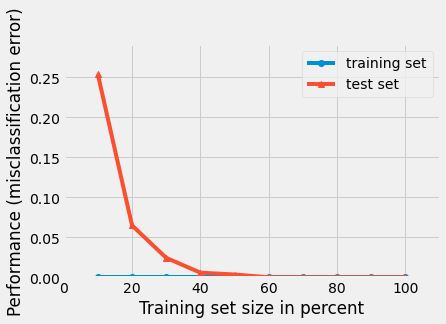

In [ ]:
plot_learning_curves(features_xtrain, y_train_np, features_xtest, y_test_np, mlp_clf, scoring='misclassification error',print_model=False)
plt.show()

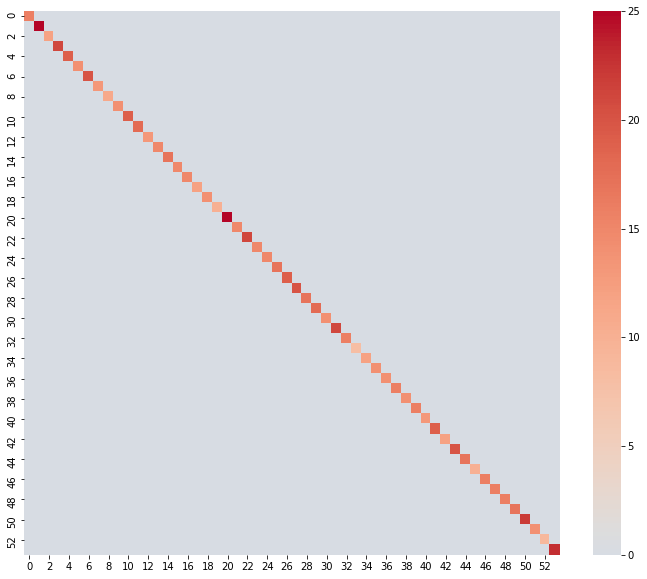

In [ ]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


0.0703209999999217


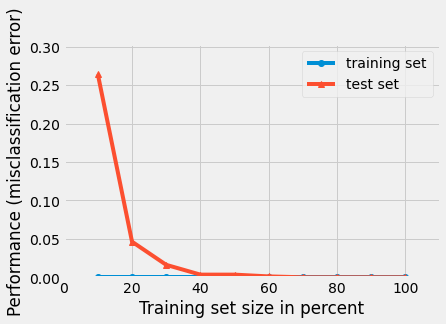

In [ ]:
#Random Forest Classifier

# Create the model with 100 trees

model_rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model_rf.fit(features_xtrain, y_train_np)
t0=time.clock()
pred_test = model_rf.predict(features_xtest) #testing accuracy

accuracy_score(y_test_np, pred_test)*100
t1=time.clock()-t0
print(t1)

from mlxtend.plotting import plot_learning_curves

plot_learning_curves(features_xtrain, y_train_np, features_xtest, y_test_np, model_rf, scoring='misclassification error',print_model=False)
plt.show()

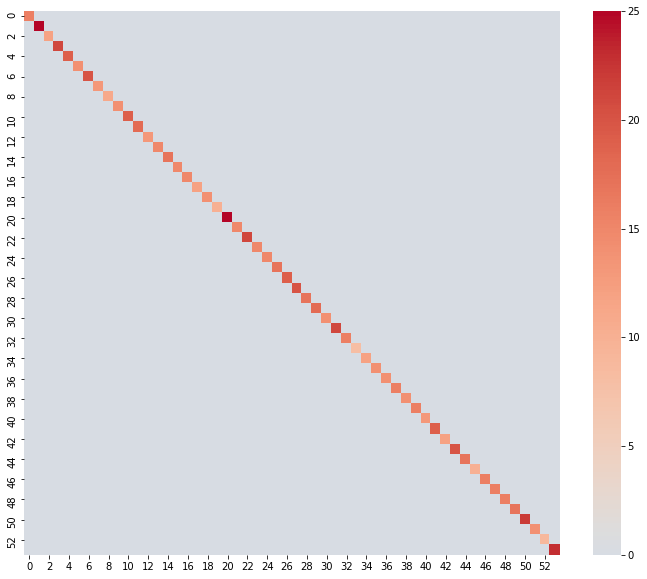

In [ ]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [ ]:
# K nearest neighbours algorithm 

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(features_xtrain, y_train_np) 
pred_test = knn.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

100.0

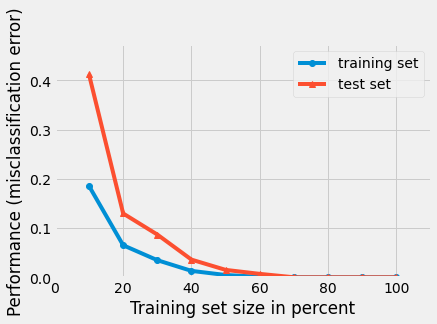

In [ ]:
#plotting training curves
from mlxtend.plotting import plot_learning_curves

plot_learning_curves(features_xtrain, y_train_np, features_xtest, y_test_np, knn, scoring='misclassification error',print_model=False)
plt.show()

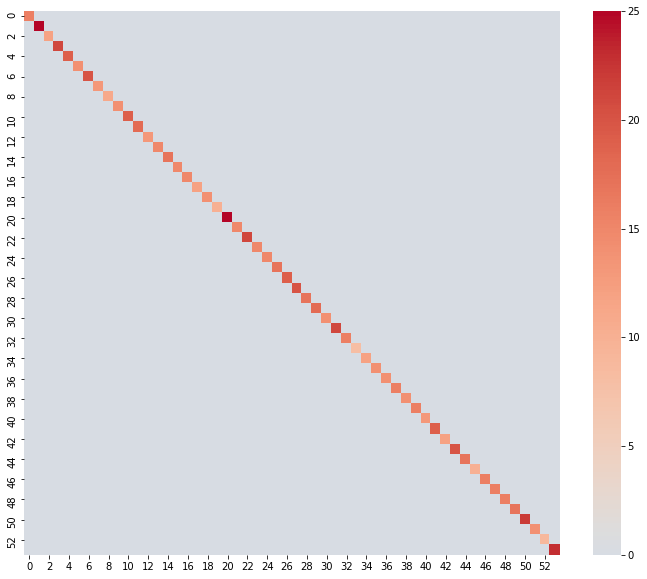

In [ ]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


0.5641700000001038


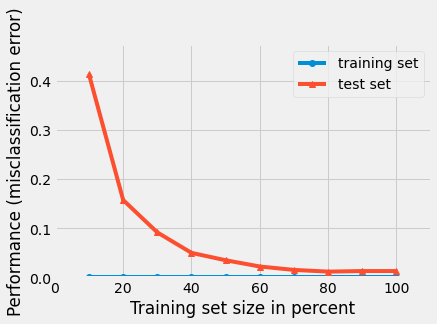

In [ ]:
# XGBoost classifier

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features_xtrain, y_train_np)
t0=time.clock()
pred_test = model.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100 
t1=time.clock()-t0
print(t1)

from mlxtend.plotting import plot_learning_curves

plot_learning_curves(features_xtrain, y_train_np, features_xtest, y_test_np, model, scoring='misclassification error',print_model=False)
plt.show()

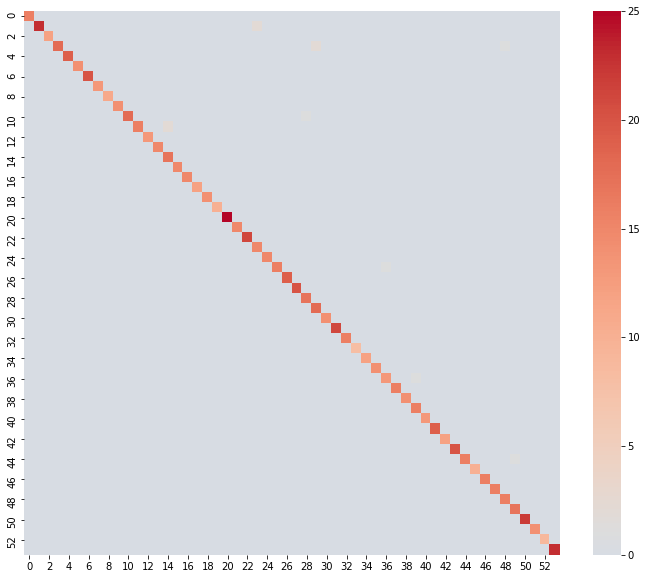

In [ ]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()